In [1]:
import pandas as pd
import numpy as np

from os import path

from zipfile import ZipFile
from os.path import expanduser, exists

from keras.callbacks import LambdaCallback, EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file

from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed

from keras.models import Sequential
from keras.layers import Dense, Activation,Embedding, Dropout
from keras.layers import LSTM, GRU
from keras.optimizers import RMSprop

from sklearn import preprocessing
import spacy
import nltk
import re
from nltk.tokenize import word_tokenize
import multiprocessing

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import string


% matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
pd.set_option('display.max_colwidth', 300) #widen pandas rows display

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16595853631853720265
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16087777280
locality {
  bus_id: 1
}
incarnation: 14993258370002378848
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0, compute capability: 6.1"
]


In [3]:
KERAS_DATASETS_DIR = expanduser('~/.keras/datasets/')
GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'


# Model related
MAX_NB_WORDS = 15000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

In [4]:
'''Load the training dataset'''

q_a_df = pd.read_csv('data/q_a_all.csv')

def clean(x):
    x = x.replace('BOS', '')
    x = x.replace('EOS', '')
    return x

def text_to_sents(text_seqs):
    tokens = re.sub(r'[^\x00-\x7f]', u'', text_seqs.lower())
    return nltk.sent_tokenize(text_seqs) # this gives us a list of sentences

q_a_df['Q'] = q_a_df['Q'].apply(clean)
q_a_df['A'] = q_a_df['A'].apply(clean)

q_a_df['Q'] = q_a_df['Q'].apply(lambda x: u' '.join(text_to_sents(x)[-2:]))
q_a_df['A'] = q_a_df['A'].apply(lambda x: u' '.join(text_to_sents(x)[:2]))

total_stories = pd.DataFrame()
total_stories['Story'] = q_a_df.apply(lambda x:'%s __EOT__ %s' % (x['Q'], x['A']), axis=1)

train_stories = pd.DataFrame(total_stories[:])
train_stories.tail()


word_count = 0
for i, row in train_stories.iterrows():
    word_count  += len(row['Story'].split())

print('Q and A average length', word_count / len(train_stories))

q_a_df[['Q','A']].to_csv('Q_A.tsv', sep='\t', encoding='utf-8', index=False)
q_a_df[['Q','A']].tail()

Q and A average length 74.8691042838598


,Q,A
27727,"Yesterday, the Prime Minister and the public safety minister suggested that the content of that media briefing was classified. Can the Prime Minister inform us who in his office helped orchestrate the release of classified information to the media?","Mr. Speaker, of course, at no point did members of the public service ever reveal classified information to the media, nor would they. The issue is that the Leader of the Opposition so wants to be able to play political games with this issue that he plugs his ears, refuses to know the truth, and..."
27728,"The Prime Minister has just affirmed that classified information was not provided to the media. Why, then, can that same information not be provided to the House?","Mr. Speaker, only Stephen Harper's Conservative Party would think that giving information to the media is somehow hiding information from Canadians. The question is: why does the Leader of the Opposition not want to know the truth?"
27729,"Mr. Speaker, in a healthy and prosperous society, it is essential to ensure that everyone can participate in the economy on a level playing field. Can the Minister of Status of Women tell us what we are doing in budget 2018 to further empower women so that they have equal opportunities to work i...","Mr. Speaker, I thank my colleague from Vimy for her leadership in advancing gender equality. By investing in women, we will improve the economy for everyone."
27730,It is unacceptable language. Could the minister please clarify what he was trying to say?,"Mr. Speaker, I was at the committee meeting yesterday. It is unfortunate that the opposition members make such personal attacks, when they have an opportunity to discuss budget 2018 and provide constructive criticism."
27731,That is his choice. I have every right to ask questions that make the government uncomfortable and I am going to continue to do it whether those members like it or not.,"Mr. Speaker, we often see in the House a type of selective amnesia. I would like to remind the House that the cabinet of the previous prime minister, Stephen Harper, was far from gender-balanced."


In [5]:
EOS_token = 'eos'
SOS_token = 'sos'
UNK_token = '<unk>'
NUM_token = '<number>'

def text_to_tokens(text_seqs):
    tokens = re.sub(r'[^\x00-\x7f]', u'', text_seqs)
    return nltk.word_tokenize(tokens)
                              
corpus = []
for i, row in q_a_df.iterrows():
    corpus.append(text_to_tokens(row['Q']))
    corpus.append(text_to_tokens(row['A']))
    
corpus = [item for sublist in corpus for item in sublist]
# print(corpus[:100])
print('number of words in Q and A:', len(corpus))

from collections import Counter
counts = Counter(corpus)
# print(counts.most_common(10000))

freq_tokens = [SOS_token, EOS_token, UNK_token, NUM_token, '__EOT__'] + list(string.punctuation)
for token in counts.most_common(10000):
    freq_tokens.append(token[0])
    
def is_number_repl_isdigit(s):
    """ Returns True is string is a number. """
    return s.replace('.','',1).isdigit()

number of words in Q and A: 2282469


In [6]:
'''Split texts into lists of words (tokens)'''



encoder = spacy.load('en')

def text_to_tokens(text_seqs):
#     token_seqs = [[word.lower_ for word in encoder(text_seq)] for text_seq in text_seqs]
#     return token_seqs
    tokens = []
    for word in nltk.word_tokenize(text_seqs.lower()):
        if word not in freq_tokens:
            word = UNK_token
        if is_number_repl_isdigit(word):
            word = NUM_token
        tokens.append(word)
    return re.sub(r'[^\x00-\x7f]',r'', u' '.join(tokens))

def _apply_df(args):
    df, func, kwargs = args
    print('df size', len(df))
    df['Tokenized_Story'] = df['Story'].apply(func, **kwargs)
    return df#df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    workers = kwargs.pop('workers')
    pool = multiprocessing.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))

num_cores = multiprocessing.cpu_count() - 1
print(num_cores) 
    
train_stories = apply_by_multiprocessing(train_stories, text_to_tokens,  workers=num_cores)
# 
# train_stories['Tokenized_Story'] = text_to_tokens(train_stories['Story'])
    
# Only 20000 records for the training set
train_stories = train_stories[:20000]
train_stories[['Story','Tokenized_Story']].tail()

7
df size 3962
df size 3962
df size 3962
df size 3962
df size 3961
df size 3961
df size 3962


,Story,Tokenized_Story
19995,"The minister keeps saying that she is talking to her Quebec counterpart and that she believes in the Canada Health Act. When will she actually enforce it? __EOT__ Mr. Speaker, I thank my colleague for her important question. As I have said, we fully subscribe to the principles of the Canada Heal...","the minister keeps saying that she is talking to her <unk> counterpart and that she believes in the <unk> health act . when will she actually enforce it ? <unk> <unk> speaker , i thank my colleague for her important question . as i have said , we fully <unk> to the principles of the <unk> health..."
19996,"It is an opportunity to discover the richness of science, technology, engineering, and mathematics in Canada. What is the Government of Canada doing to encourage all Canadians to learn about and to engage with scientific research, and to seriously consider a career in science? __EOT__ Mr. Speake...","it is an opportunity to discover the <unk> of science , technology , engineering , and <unk> in <unk> . what is the government of <unk> doing to encourage all <unk> to learn about and to engage with scientific research , and to seriously consider a career in science ? <unk> <unk> speaker , i wou..."
19997,"Now the Ethics Commissioner has ruled that a conflict of interest does exist, and the chief of staff must recuse herself of most major files in the minister's department. If she cannot talk about agriculture, and if she cannot talk about trade, what is she still doing there? __EOT__ Mr. Speaker,...","now the ethics commissioner has ruled that a conflict of interest does exist , and the chief of staff must recuse herself of most major files in the minister 's department . if she can not talk about agriculture , and if she can not talk about trade , what is she still doing there ? <unk> <unk> ..."
19998,"Mr. Speaker, that was the same talking points that he gave to me on January 25, but we found out just recently from the Ethics Commissioner that her new ruling requires that his chief of staff not engage with the TPP, not have any involvement with regard to the egg industry, and have nothing to ...","<unk> speaker , that was the same talking points that he gave to me on <unk> <number> , but we found out just recently from the ethics commissioner that her new ruling requires that his chief of staff not engage with the <unk> , not have any involvement with regard to the egg industry , and have..."
19999,"The minister refused to listen to us. How can the minister assure farmers and processors that his chief of staff has not been using this job for personal gain? __EOT__ Mr. Speaker, I know the member for Lambton—Kent—Middlesex, and I am surprised that he would indicate that such a competent lady ...","the minister refused to listen to us . how can the minister assure farmers and processors that his chief of staff has not been using this job for personal gain ? <unk> <unk> speaker , i know the member for <unk> , and i am surprised that he would indicate that such a competent <unk> would be in ..."


In [7]:


tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      lower=True, split=' ', filters='"#%&()*+-/<=>@[\\]^_`{|}~\t\n',
                      char_level=False, oov_token=u'<UNK>')

tokenizer.fit_on_texts(train_stories['Tokenized_Story'].values)
q_a_word_sequences = tokenizer.texts_to_sequences(train_stories['Tokenized_Story'].values)

word_index = tokenizer.word_index

print("Words in index: %d" % len(word_index))
print('word_index', dict(list(word_index.items())[:20]))

index_word = {v: k for k, v in word_index.items()}
# Add empty to 
index_word[0] = '' #map 0 padding to empty string
print('index_word', dict(list(index_word.items())[:20]))

vocab_size = len(word_index) + 1

Words in index: 7689
word_index {'unk': 1, 'the': 2, ',': 3, '.': 4, 'to': 5, 'of': 6, 'and': 7, 'that': 8, 'is': 9, 'in': 10, '?': 11, 'speaker': 12, 'a': 13, 'for': 14, 'we': 15, 'will': 16, 'this': 17, 'government': 18, 'minister': 19, 'are': 20}
index_word {1: 'unk', 2: 'the', 3: ',', 4: '.', 5: 'to', 6: 'of', 7: 'and', 8: 'that', 9: 'is', 10: 'in', 11: '?', 12: 'speaker', 13: 'a', 14: 'for', 15: 'we', 16: 'will', 17: 'this', 18: 'government', 19: 'minister', 20: 'are'}


In [8]:
%%time


# Run once only
if not exists(KERAS_DATASETS_DIR + GLOVE_FILE):
    zipfile = ZipFile(get_file(GLOVE_ZIP_FILE, GLOVE_ZIP_FILE_URL))
    zipfile.extract(GLOVE_FILE, path=KERAS_DATASETS_DIR)
    
print("Processing", GLOVE_FILE)

embeddings_index = {}
with open(KERAS_DATASETS_DIR + GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

Processing glove.840B.300d.txt
Word embeddings: 2196016
CPU times: user 2min 21s, sys: 4.24 s, total: 2min 26s
Wall time: 2min 26s


In [9]:
%%time


nb_words = min(MAX_NB_WORDS, len(word_index))
print(nb_words, len(word_index))
# word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
embedding_matrix = np.random.uniform(-1, 1, size=(nb_words + 1, EMBEDDING_DIM))
count = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector[:EMBEDDING_DIM]
        count += 1

print('L2 Normalization')

# l2-normalize the samples (rows). 
embedding_matrix = preprocessing.normalize(embedding_matrix, norm='l2')

vocab_size = nb_words + 1
print('vocab size', vocab_size)
print('Null word embeddings: %d' % (vocab_size - count))

7689 7689
L2 Normalization
vocab size 7690
Null word embeddings: 5
CPU times: user 24 ms, sys: 8 ms, total: 32 ms
Wall time: 33.3 ms


## Model Building....     





In [10]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
#     print(model_history.history)
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [11]:

'''Create the model'''


def GRU_Deep_model(seq_input_len, n_input_nodes, n_embedding_nodes, 
                 n_hidden_nodes, stateful=False, batch_size=None):

    input_layer = Input(batch_shape=(batch_size, seq_input_len), name='input_layer')
 
    embedding_layer = Embedding(vocab_size, EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)(input_layer)

    gru_layer1 = GRU(n_hidden_nodes, dropout=0.2,
                     recurrent_initializer='he_uniform', kernel_initializer='he_uniform',
                     return_sequences=True, #return hidden state for each word, not just last one
                     stateful=stateful, name='hidden_layer1')(embedding_layer)

    gru_layer2 = GRU(n_hidden_nodes, dropout=0.2,
                     recurrent_initializer='he_uniform', kernel_initializer='he_uniform',
                     return_sequences=True,
                     stateful=stateful, name='hidden_layer2')(gru_layer1)

    output_layer = TimeDistributed(Dense(n_input_nodes, activation="softmax"), 
                                   name='output_layer')(gru_layer2)

    model = Model(inputs=input_layer, outputs=output_layer)

    #Specify loss function and optimization algorithm, compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    
    return model


def LSTM_Deep_model(seq_input_len, n_input_nodes, n_embedding_nodes, 
                 n_hidden_nodes, stateful=False, batch_size=None):

    input_layer = Input(batch_shape=(batch_size, seq_input_len), name='input_layer')
 
    embedding_layer = Embedding(vocab_size, EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)(input_layer)
    gru_layer1 = LSTM(n_hidden_nodes, dropout=0.2,
                     recurrent_initializer='he_uniform', kernel_initializer='he_uniform',
                     return_sequences=True, #return hidden state for each word, not just last one
                     stateful=stateful, name='hidden_layer1')(embedding_layer)
    gru_layer2 = LSTM(n_hidden_nodes, dropout=0.2,
                     recurrent_initializer='he_uniform', kernel_initializer='he_uniform',
                     return_sequences=True,
                     stateful=stateful, name='hidden_layer2')(gru_layer1)
    output_layer = TimeDistributed(Dense(n_input_nodes, activation="softmax"), 
                                   name='output_layer')(gru_layer2)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    return model


def LSTM_valina_model(seq_input_len, n_input_nodes, n_embedding_nodes, 
                 n_hidden_nodes, stateful=False, batch_size=None):
    
    input_layer = Input(batch_shape=(batch_size, seq_input_len), name='input_layer')  
    
    embedding_layer = Embedding(vocab_size, EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)(input_layer)
    
    gru_layer1 = LSTM(n_hidden_nodes, dropout=0.2,
                     recurrent_initializer='he_uniform', kernel_initializer='he_uniform',
                     return_sequences=True, 
                     stateful=stateful, name='hidden_layer1')(embedding_layer)
    
    output_layer = TimeDistributed(Dense(n_input_nodes, activation="softmax"), 
                                   name='output_layer')(gru_layer1)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

    return model

def GRU_valina_model(seq_input_len, n_input_nodes, n_embedding_nodes, 
                 n_hidden_nodes, stateful=False, batch_size=None):
    
    input_layer = Input(batch_shape=(batch_size, seq_input_len), name='input_layer')  
    
    embedding_layer = Embedding(vocab_size, EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)(input_layer)
    
    gru_layer1 = GRU(n_hidden_nodes, dropout=0.2,
                     recurrent_initializer='he_uniform', kernel_initializer='he_uniform',
                     return_sequences=True, #return hidden state for each word, not just last one
                     stateful=stateful, name='hidden_layer1')(embedding_layer)
    
    output_layer = TimeDistributed(Dense(n_input_nodes, activation="softmax"), 
                                   name='output_layer')(gru_layer1)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    
    return model

In [12]:
q_a_data_padded = pad_sequences(q_a_word_sequences, 
                                maxlen=MAX_SEQUENCE_LENGTH + 1)

print('Shape of question & answer data tensor:', q_a_data_padded.shape)
# print(q_a_data_padded[:,:20])

pd.DataFrame(list(zip(q_a_data_padded[0,:-1], q_a_data_padded[0, 1:])),
                columns=['Input Words', 'Output Words']).tail()


Shape of question & answer data tensor: (20000, 101)


,Input Words,Output Words
95,701,6
96,6,8
97,8,200
98,200,123
99,123,4


In [13]:
'''Train the model'''


# define early stopping callback
earlystop = EarlyStopping(monitor='loss', patience=2, verbose=1, mode='auto')
# checkpoint
filepath="data/2XGRU-NLG-{epoch:02d}-{loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [earlystop]

epochs=100
batch_size=128

x = q_a_data_padded[:,:-1]
y = q_a_data_padded[:, 1:, None]


# y=train_padded_idxs[:, 1:]
print('x.shape', x.shape)
print('y.shape', y.shape)
print(q_a_data_padded.shape)


LSTM_valina = LSTM_valina_model(seq_input_len=q_a_data_padded.shape[-1] - 1, #substract 1 from matrix length because of offset 
                     n_input_nodes = vocab_size + 1, # Add 1 to account for 0 padding
                     n_embedding_nodes = EMBEDDING_DIM,
                     n_hidden_nodes = 128)

GRU_valina = GRU_valina_model(seq_input_len=q_a_data_padded.shape[-1] - 1, #substract 1 from matrix length because of offset 
                     n_input_nodes = vocab_size + 1, # Add 1 to account for 0 padding
                     n_embedding_nodes = EMBEDDING_DIM,
                     n_hidden_nodes = 128)

GRU_Deep = GRU_Deep_model(seq_input_len=q_a_data_padded.shape[-1] - 1, #substract 1 from matrix length because of offset 
                     n_input_nodes = vocab_size + 1, # Add 1 to account for 0 padding
                     n_embedding_nodes = EMBEDDING_DIM,
                     n_hidden_nodes = 128)

LSTM_Deep = LSTM_Deep_model(seq_input_len=q_a_data_padded.shape[-1] - 1, #substract 1 from matrix length because of offset 
                     n_input_nodes = vocab_size + 1, # Add 1 to account for 0 padding
                     n_embedding_nodes = EMBEDDING_DIM,
                     n_hidden_nodes = 128)


x.shape (20000, 100)
y.shape (20000, 100, 1)
(20000, 101)


In [14]:

# def batch(x, y, n=1000):
#     l = len(x)
#     while True:
#         for ndx in range(0, l, n):
#             yield (x[ndx:min(ndx + n, l)], y[ndx:min(ndx + n, l)])
#         break
        
# for X_batch, Y_batch in batch(x, y, 500):
#     print (X_batch.shape, Y_batch.shape)
    


************************* GRU_Deep_model *************************
File path of model weights:  data/q_a_only_GRU_Deep_model_weights.h5
.h5 file not found
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 100)          769000    
_________________________________________________________________
hidden_layer1 (GRU)          (None, 100, 128)          87936     
_________________________________________________________________
hidden_layer2 (GRU)          (None, 100, 128)          98688     
_________________________________________________________________
output_layer (TimeDistribute (None, 100, 7691)         992139    
Total params: 1,947,763
Trainable params: 1,947,763
Non-trainable params: 0
___________________________________________

19000/19000 [==============================] - 53s 3ms/step - loss: 2.6261 - acc: 0.4948 - val_loss: 2.8700 - val_acc: 0.4754
Epoch 52/100
19000/19000 [==============================] - 54s 3ms/step - loss: 2.6222 - acc: 0.4951 - val_loss: 2.8657 - val_acc: 0.4766
Epoch 53/100
19000/19000 [==============================] - 53s 3ms/step - loss: 2.6179 - acc: 0.4953 - val_loss: 2.8639 - val_acc: 0.4767
Epoch 54/100
19000/19000 [==============================] - 53s 3ms/step - loss: 2.6142 - acc: 0.4958 - val_loss: 2.8635 - val_acc: 0.4770
Epoch 55/100
19000/19000 [==============================] - 53s 3ms/step - loss: 2.6104 - acc: 0.4961 - val_loss: 2.8609 - val_acc: 0.4753
Epoch 56/100
19000/19000 [==============================] - 53s 3ms/step - loss: 2.6074 - acc: 0.4965 - val_loss: 2.8603 - val_acc: 0.4757
Epoch 57/100
19000/19000 [==============================] - 54s 3ms/step - loss: 2.6037 - acc: 0.4965 - val_loss: 2.8614 - val_acc: 0.4764
Epoch 58/100
19000/19000 [==============

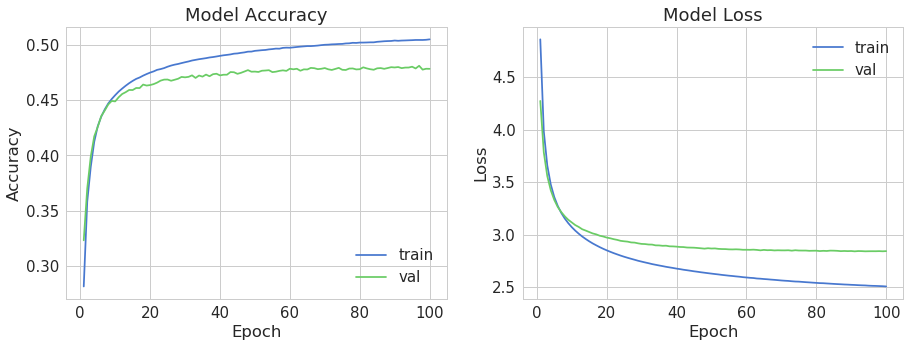

In [16]:
model_list = {
   # 'LSTM_valina_model' : LSTM_valina, 'GRU_valina_model' : GRU_valina,
    'GRU_Deep_model': GRU_Deep,# 'LSTM_Deep_model' : LSTM_Deep
             }

for name, model in model_list.items():

    print('*' * 25, name, '*' * 25)
    # Check if weights file exists, should not exist only for first run
    file_path = 'data/q_a_only_%s_weights.h5' % name
    print ('File path of model weights: ', file_path)
    if path.isfile(file_path):
        print ('found file, loading weights... ')
        model.load_weights(file_path)
    else:
        print ('.h5 file not found')
   
    model.summary()
    #     output matrix (y) has extra 3rd dimension added because sparse cross-entropy function requires one label per row
    model_info = model.fit(x, y, verbose=1,
              validation_split=0.05, callbacks=callbacks_list, 
              epochs=epochs, batch_size=batch_size)
#     model_info = model.fit_generator(batch(x, y, 500), steps_per_epoch=100, epochs=1)   
    model.save_weights(file_path) #Save model
#     model_info_list[name] = model_info.history
    plot_model_history(model_info)

In [17]:
index_word[3480]
word_index['?']

11

# Generation

In [18]:
'''Create a new test model, setting batch_size = 1, seq_input_len = 1, and stateful = True'''

# Load lexicon from the saved model 
# with open('data/lexicon.pkl', 'rb') as f:
#     lexicon = pickle.load(f)
# lexicon_lookup = get_lexicon_lookup(lexicon)

predictor_model = GRU_Deep_model(seq_input_len=1,
                               n_input_nodes=vocab_size + 1,
                               n_embedding_nodes = EMBEDDING_DIM,
                               n_hidden_nodes = 128,
                               stateful=True, 
                               batch_size = 1)

predictor_model.load_weights('data/q_a_only_GRU_Deep_model_weights.h5') #Load weights from saved model

In [19]:

def text_to_tokens(text_seqs):
    tokens = nltk.word_tokenize(text_seqs.lower())
    return re.sub(r'[^\x00-\x7f]',r'', u' '.join(tokens)).split()

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def generate_ending(idx_seq, diversity=1.0):
    
    end_of_sent_tokens = [".", "!", "?"]
    generated_ending = []
    
    # First just read initial story, no output needed
    for word in idx_seq:
        p_next_word = predictor_model.predict(np.array(word)[None,None])[0,0]
        
    count = 0
    number_of_sents = 0
    # Now start predicting new words
#     while not generated_ending or index_word[next_word] not in end_of_sent_tokens:
    while True:
#         print('hereee')
        next_word = sample(p_next_word, diversity)
        #Randomly sample a word from the current probability distribution
#         next_word = np.random.choice(a=p_next_word.shape[-1], p=p_next_word)
#         print(next_word)
        # Append sampled word to generated ending
        generated_ending.append(next_word)
        
        # Get probabilities for next word by inputing sampled word
        p_next_word = predictor_model.predict(np.array(next_word)[None,None])[0,0]
        
        if index_word[next_word] in end_of_sent_tokens:
            number_of_sents += 1
            
        if number_of_sents == 2:
            break
        
        if next_word == 0:
            count += 1
        if count == 10:
            break 
    
    predictor_model.reset_states() #reset hidden state after generating ending
    
    return u' '.join([index_word[word] if word in index_word else ""
                                 for word in generated_ending]) #decode from numbers back into words
    


def gen_chat_response(text):

#     print(text)
    text_tokens = text_to_tokens(text)        
#     print(text_tokens)
    
    tokens_idxs = tokenizer.texts_to_sequences(text_tokens)
    tokens_idxs = [item for sublist in tokens_idxs for item in sublist]
#     print(tokens_idxs)
#     for diversity in [0.2]:
    responses = {}
    for diversity in [0.2,0.4, 0.6, 0.8, 1, 1.2]:
        generated_ending = generate_ending(tokens_idxs, diversity)
        responses[diversity] = generated_ending
#         print("Text:", diversity, generated_ending, "\n")
    
    return responses
        

text = 'liberal refuee plan?'
gen_chat_response(text)

{0.2: 'unk unk speaker , i am pleased to inform the house that we have been very clear that the unk are in charge of the unk government , and we are trying to make sure that unk are unk and unk . we have been very clear that we have been very clear that we have a strong record of the unk government .',
 0.4: "unk unk speaker , we have been very clear that we have made sure that we have a strong record of accountability and that we have been clear . that is why we have made significant investments in the unk coast guard and unk 's unk to ensure that the unk are safe and secure .",
 0.6: "unk unk speaker , we are keeping our streets and communities safe . we are pleased to see that this government is focused on what matters to unk 's economy .",
 0.8: "unk unk speaker , this is a common practice with respect to asylum seekers , and we have asked them to do that , but they should be able to engage in the time to participate in the unk involving the unk . so , did the unk the unk in any wa

In [27]:
def text_to_sents(text_seqs):
    tokens = nltk.word_tokenize(text_seqs.lower())
    return re.sub(r'[^\x00-\x7f]',r'', u' '.join(tokens)).split()

df = pd.read_csv('NLG_Hansard_generated_responses.tsv', sep='\t')

response = []
for i, row in df.iterrows():
    responses = gen_chat_response(row['Q'])
    response.append(responses)  
    
print(response)

df = df.join(pd.DataFrame(response))

df.to_csv('NLG_Hansard_generated_responses.tsv', sep='\t')
df.tail()


KeyboardInterrupt: 